# 迁移学习示例（Transfer Learning Example）

使用迁移学习，训练一个识别猫和老虎的分类器。  
这里使用的是tensorflow的构建方法，比较的古老了。

### 导入模块

In [1]:
from urllib.request import urlretrieve
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt

D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anacanda\envs\tensorflow1.14.0\lib\site-packages\tensorflow\python\framework

### 查看是否使用立即执行

In [2]:
tf.executing_eagerly()

False

In [3]:
#tf.enable_eager_execution()

### 下载训练集

由于数据集原网站无法下载，可以提前在[百度云下载](https://pan.baidu.com/s/1weg_hw-F9wVjK0J7ldjNZw)。

下载后的数据保存到对应的文件夹下，使用numpy加载数据。

In [4]:
def load_img(path):
    """
    输入图片所在的路径+名称
    从path位置读入单张的图片到img，
    将数据归一化，
    从图片中心点裁剪，成为正方形，
    重整图片尺寸（m, 宽, 高, channel）
    return：一张shape为(1, 224, 224, 3)的图片
    """
    img = skimage.io.imread(path)
    img = img / 255.0
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (224, 224))[None, :, :, :]   # shape [1, 224, 224, 3]
    return resized_img

我们打印一张图片看看效果和实际的shape。

(1, 224, 224, 3)


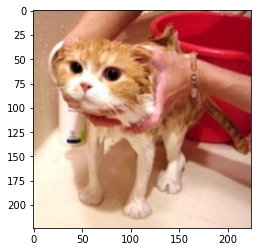

In [5]:
img_example = load_img('for_transfer_learning/data/kittycat/10fa4b717a5.jpg')
print(img_example.shape)
plt.imshow(img_example[0])

现在可以从文件夹中大批量的加载数据。

In [6]:
def load_data():
    """
    老虎和猫都加载400张图片和标签
    """
    imgs = {'tiger': [], 'kittycat': []}
    for k in imgs.keys():
        dir = './for_transfer_learning/data/' + k
        for file in os.listdir(dir):
            if not file.lower().endswith('.jpg'):
                continue
            try:
                resized_img = load_img(os.path.join(dir, file))
            except OSError:
                continue
            imgs[k].append(resized_img)    # [1, height, width, depth] * n
            if len(imgs[k]) == 400:        # only use 400 imgs to reduce my memory load
                break
    # fake length data for tiger and cat
    tigers_y = np.maximum(20, np.random.randn(len(imgs['tiger']), 1) * 30 + 100)
    cat_y = np.maximum(10, np.random.randn(len(imgs['kittycat']), 1) * 8 + 40)
    return imgs['tiger'], imgs['kittycat'], tigers_y, cat_y

加载所有数据试试看。

In [7]:
tigers_x, cats_x, tigers_y, cats_y = load_data()

In [8]:
print('tigers_x, cats_x, tigers_y, cats_y count is {0}, {1}, {2}, {3} '.format( len(tigers_x), len(cats_x), len(tigers_y), len(cats_y)) )

tigers_x, cats_x, tigers_y, cats_y count is 400, 400, 400, 400 


### 定义VGG模型

In [9]:
class Vgg16:
    """
    vgg_mean 是VGG网络的在三个channel方向上的参数
    """
    vgg_mean = [103.939, 116.779, 123.68]
    def __init__(self, vgg16_npy_path=None, restore_from=None):
        """
        vgg16_npy_path： 模型所在的path
        
        使用numpy从文件中恢复已经训练好了的VGG-16模型，
        将图片处理三通道都减去vgg_mean，rgb转为bgr
        """
        try:
            np_load_old = np.load
            # modify the default parameters of np.load
            np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
            self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
            np.load = np_load_old
        except FileNotFoundError:
            print('Please download VGG16 parameters from here https://mega.nz/#!YU1FWJrA!O1ywiCS2IiOlUCtCpI6HTJOMrneN-Qdv3ywQP5poecM\nOr from my Baidu Cloud: https://pan.baidu.com/s/1Spps1Wy0bvrQHH2IMkRfpg')
        
        self.tfx = tf.placeholder(tf.float32, [None, 224, 224, 3])
        self.tfy = tf.placeholder(tf.float32, [None, 1])
        
        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=self.tfx * 255.0)
        bgr = tf.concat(axis=3, values=[
            blue - self.vgg_mean[0],
            green - self.vgg_mean[1],
            red - self.vgg_mean[2],
        ])
        
        # pre-trained VGG layers are fixed in fine-tune
        conv1_1 = self.conv_layer(bgr, "conv1_1")
        conv1_2 = self.conv_layer(conv1_1, "conv1_2")
        pool1 = self.max_pool(conv1_2, 'pool1')

        conv2_1 = self.conv_layer(pool1, "conv2_1")
        conv2_2 = self.conv_layer(conv2_1, "conv2_2")
        pool2 = self.max_pool(conv2_2, 'pool2')

        conv3_1 = self.conv_layer(pool2, "conv3_1")
        conv3_2 = self.conv_layer(conv3_1, "conv3_2")
        conv3_3 = self.conv_layer(conv3_2, "conv3_3")
        pool3 = self.max_pool(conv3_3, 'pool3')

        conv4_1 = self.conv_layer(pool3, "conv4_1")
        conv4_2 = self.conv_layer(conv4_1, "conv4_2")
        conv4_3 = self.conv_layer(conv4_2, "conv4_3")
        pool4 = self.max_pool(conv4_3, 'pool4')

        conv5_1 = self.conv_layer(pool4, "conv5_1")
        conv5_2 = self.conv_layer(conv5_1, "conv5_2")
        conv5_3 = self.conv_layer(conv5_2, "conv5_3")
        pool5 = self.max_pool(conv5_3, 'pool5')

        # detach original VGG fc layers and
        # reconstruct your own fc layers serve for your own purpose
        self.flatten = tf.reshape(pool5, [-1, 7*7*512])
        self.fc6 = tf.layers.dense(self.flatten, 256, tf.nn.relu, name='fc6')
        self.out = tf.layers.dense(self.fc6, 1, name='out')

        self.sess = tf.Session()
        if restore_from:
            saver = tf.train.Saver()
            saver.restore(self.sess, restore_from)
        else:   # training graph
            self.loss = tf.losses.mean_squared_error(labels=self.tfy, predictions=self.out)
            self.train_op = tf.train.RMSPropOptimizer(0.001).minimize(self.loss)
            self.sess.run(tf.global_variables_initializer())
        
    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)
    
    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):   # CNN's filter is constant, NOT Variable that can be trained
            conv = tf.nn.conv2d(bottom, self.data_dict[name][0], [1, 1, 1, 1], padding='SAME')
            lout = tf.nn.relu(tf.nn.bias_add(conv, self.data_dict[name][1]))
            return lout
    
    def train(self, x, y):
        loss, _ = self.sess.run([self.loss, self.train_op], {self.tfx: x, self.tfy: y})
        return loss

    def predict(self, paths):
        fig, axs = plt.subplots(1, 2)
        for i, path in enumerate(paths):
            x = load_img(path)
            length = self.sess.run(self.out, {self.tfx: x})
            axs[i].imshow(x[0])
            axs[i].set_title('Len: %.1f cm' % length)
            axs[i].set_xticks(()); axs[i].set_yticks(())
        plt.show()

    def save(self, path='./for_transfer_learning/model/transfer_learn'):
        saver = tf.train.Saver()
        saver.save(self.sess, path, write_meta_graph=False)

In [10]:
def train(tigers_x, cats_x, tigers_y, cats_y ):
    # plot fake length distribution
    plt.hist(tigers_y, bins=20, label='Tigers')
    plt.hist(cats_y, bins=10, label='Cats')
    plt.legend()
    plt.xlabel('length')
    plt.show()

    xs = np.concatenate(tigers_x + cats_x, axis=0)
    ys = np.concatenate((tigers_y, cats_y), axis=0)

    vgg = Vgg16(vgg16_npy_path='./for_transfer_learning/vgg16.npy')
    print('Net built')
    for i in range(100):
        b_idx = np.random.randint(0, len(xs), 6)
        train_loss = vgg.train(xs[b_idx], ys[b_idx])
        print(i, 'train loss: ', train_loss)

    vgg.save('./for_transfer_learning/model/transfer_learn')      # save learned fc layers

In [11]:
def eval():
    vgg = Vgg16(vgg16_npy_path='./for_transfer_learning/vgg16.npy',
                restore_from='./for_transfer_learning/model/transfer_learn')
    vgg.predict(
        ['./for_transfer_learning/data/kittycat/000129037.jpg', './for_transfer_learning/data/tiger/391412.jpg'])

### 训练

In [12]:
#train(tigers_x, cats_x, tigers_y, cats_y )

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./for_transfer_learning/model/transfer_learn


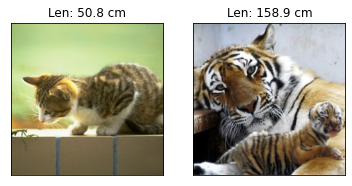

In [13]:
eval()